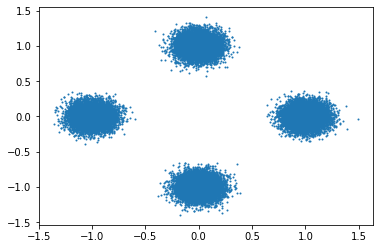

In [90]:
import torch
import torch.nn.functional as nn
import torch.autograd as autograd
import random
import torch.nn.init as init
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


class CustomDataSet(torch.utils.data.Dataset):

    def __init__(self, n_group, n_data):

        self.n_group = n_group
        self.n_data = n_data
        _data = np.random.randn(self.n_data, 2)
        _label = np.ndarray(self.n_data, dtype=np.int)
        _mu = []
        _sig = 0.1
        for k in range(n_group):
            _mu.append([np.cos(2.0 * np.pi * k / n_group), np.sin(2.0 * np.pi * k / n_group)])
        for i in range(n_data):
            _data[i][0] = _sig * _data[i][0] + _mu[i % n_group][0]
            _data[i][1] = _sig * _data[i][1] + _mu[i % n_group][1]
            _label[i] = i % n_group

        self.data = torch.as_tensor(_data, dtype=torch.float32)
        self.label = torch.as_tensor(_label, dtype=torch.int64)

    def __len__(self):
        return self.n_data

    def __getitem__(self, idx):
        # return self.data[idx], self.label[idx]
        return self.data[idx]


data_size = 40000
dataset = CustomDataSet(n_group=4, n_data=data_size)

data_points = dataset.data.numpy()
plt.scatter(data_points[:, 0], data_points[:, 1], s=1)
plt.show()
device = 'cpu'

In [92]:
eps = 1e-20

def rand_gumbel(shape):
    u = torch.rand(shape)
    return -torch.log(-torch.log(u + 1e-20) + 1e-20)


def gumbel_softmax_sample(logits, tau):
    """
    logits == normalized or unnormalized log_pi
    
    unnormalized log_pi = softmax 의 입력
    normalized log_pi = log(softmax(softmax 의 입력))
    
    input = shape(*, n_class)
    return.shape: [*, n_class], gumbel_softmax vector
    """
    y = logits + rand_gumbel(logits.shape)
    return torch.nn.functional.softmax(y / tau, dim=-1)


def ST_gumbel_softmax_sample(logits, tau):
    """
    input = shape(*, n_class)
    return.shape: [*, n_class], one-hot vector
    """
    y = gumbel_softmax_sample(logits, tau)
    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y # ignore one hot derivative 


def log_importance_weight_matrix(batch_size, dataset_size):

    N = dataset_size
    M = batch_size 
    strat_weight = (1.0 / M) *((N - M)/(N * (M - 1.0)) + 1.0)
    W = torch.Tensor(batch_size, batch_size).fill_(strat_weight)
    W.view(-1)[::M + 1] = 1 / N
    return W.log()


class Discriminator(torch.nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer = torch.nn.Sequential(
            torch.nn.Linear(in_features=2, out_features=16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=3, bias=True),
        ).to(device)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        logits = self.layer(x)
        return logits, self.softmax(logits)


def kaiming_init(m):
    if isinstance(m, (torch.nn.Linear, torch.nn.Conv2d)):
        init.kaiming_normal_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (torch.nn.BatchNorm1d, torch.nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)

In [118]:
mb_size = 256
loader = torch.utils.data.DataLoader(dataset=dataset,
                                     batch_size=mb_size,
                                     shuffle=True,
                                     drop_last=True)

discriminator = Discriminator()
log_weights = log_importance_weight_matrix(mb_size, data_size)
d_solver = optim.Adam(discriminator.parameters(), lr=0.0001, weight_decay=0.0001)

In [123]:
def log_mass(y, theta):
    return torch.sum(y * torch.log(theta + 1e-7), dim=-1)

MI = []
num_epochs = 100
for epoch in range(num_epochs):
    MI_AVG = 0.0
    for _, X in enumerate(loader):
        X = X.to(device)
        d_solver.zero_grad()
        logits, pi = discriminator(X)
        sample_y = ST_gumbel_softmax_sample(logits, 0.01)


        batch_log_py = log_mass(sample_y.view(mb_size, 1, 3), pi.view(1, mb_size, 3))

        H_Y_GIVEN_X = torch.mean(torch.sum(-pi * torch.log(pi + 1e-7), dim=1))

        H_Y = -torch.mean(batch_log_py) * 3

        MUTUAL_INFOMATION = H_Y - H_Y_GIVEN_X
        (-MUTUAL_INFOMATION).backward()
        d_solver.step()
        MI_AVG += MUTUAL_INFOMATION.item()
    MI_AVG /= len(loader)
    print(MI_AVG)
    MI.append(MI_AVG)

30.092555657411232
30.12035692655123
30.108042325728977
30.107915095793896
30.103866650508
30.11145418118208
30.094992857712967
30.09379382011218
30.112170243874573
30.104314204974052
30.102654237013596
30.111605106255947
30.10442332732372
30.093281232393704
30.08465071213551
30.09374517049545
30.091781995235344
30.10070810562525
30.105951162484978
30.098895720946484
30.10091122602805
30.095655111166145
30.12113599288158


KeyboardInterrupt: ignored

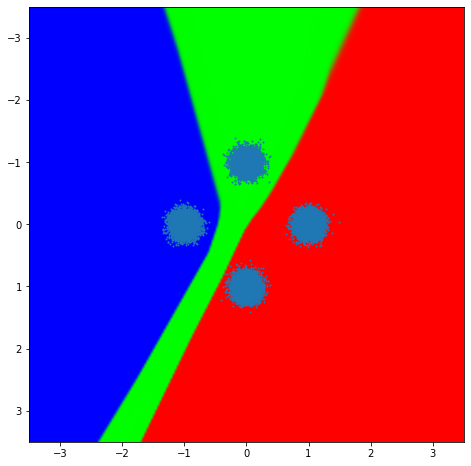

In [124]:

resol = 200
left_point = -3.5
right_point = 3.5
offset = (right_point - (left_point))/resol 

p = np.ones((resol, resol, 3), np.float64)


x_region = torch.zeros((resol, resol, 2), dtype=torch.float)
for a_step in range(resol):
    for b_step in range(resol):
        x_region.data[a_step][b_step][0] = left_point + offset * (a_step)
        x_region.data[a_step][b_step][1] = left_point + offset * (b_step)

_, y = discriminator(x_region.reshape(-1, 2))
y = y.reshape(resol, resol, 3)
for a_step in range(resol):
    for b_step in range(resol):
        p[b_step][a_step][0] = y[b_step][a_step][0]
        p[b_step][a_step][1] = y[b_step][a_step][1]
        p[b_step][a_step][2] = y[b_step][a_step][2]

plt.figure(figsize=(8,8))

plt.imshow(p, interpolation='spline36', extent=[left_point, right_point, right_point, left_point])  #first dim = y axis,  second dim = x axis
plt.scatter(data_points[:, 0], data_points[:, 1], s=1)
plt.show()